In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import datetime as dt
import matplotlib.dates as md
import ipywidgets as widgets
from IPython.display import display

In [2]:
# df = pd.read_csv("../data/activity_2023_02_15_2.csv")
df = pd.read_csv("../data/P001/Irregular/P001_Irregular.txt", sep=" ", header=None, names=['wristX', 'wristY', 'wristZ',
                                                                                                                'hipX', 'hipY', 'hipZ',
                                                                                                               'ankleX', 'ankleY', 'ankleZ'])

In [3]:
df_ground_truth = pd.read_csv("../data/P001/Irregular/steps.txt", header=None)
df_ground_truth

,0
0,12 right
1,27 left
2,38 right
3,47 left
4,56 right
...,...
194,8074 left
195,8084 right
196,8092 leftshift
197,8112 rightshift


In [4]:
# print("df_shape:", df.shape)
df

,wristX,wristY,wristZ,hipX,hipY,hipZ,ankleX,ankleY,ankleZ
0,-0.151428,0.981339,-0.448547,0.094315,1.120621,0.306641,0.065948,1.042755,0.060471
1,-0.548889,0.745132,-0.269226,-0.185959,0.776871,0.297607,0.032501,1.037750,0.061813
2,-0.671570,0.528214,-0.273987,0.029373,0.790298,0.326416,0.111115,0.999908,0.086349
3,-0.436584,0.598526,-0.242859,0.186111,0.858658,0.329102,0.073761,1.026398,0.030685
4,-0.559753,0.776505,-0.264099,0.072464,0.894058,0.300415,0.126251,1.010284,0.069260
...,...,...,...,...,...,...,...,...,...
8675,-0.393372,0.285294,0.867249,-0.146896,0.976089,0.171753,0.122223,1.008331,0.122116
8676,-0.382385,0.265152,0.881042,-0.153610,0.978409,0.172363,0.123199,1.010040,0.119308
8677,-0.388855,0.275284,0.844788,-0.149948,0.984390,0.170898,0.123199,1.008698,0.120529
8678,-0.390930,0.268204,0.866638,-0.151535,0.980850,0.171143,0.122833,1.008820,0.121750


0.0
0.06667434804316934
0.13334869608633867


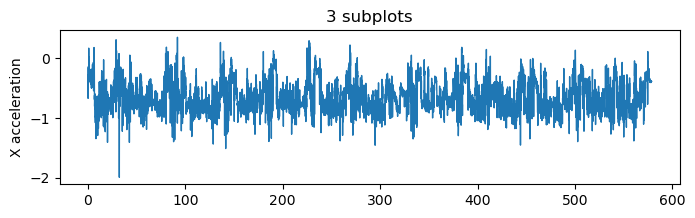

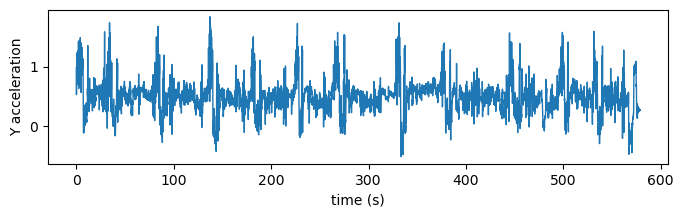

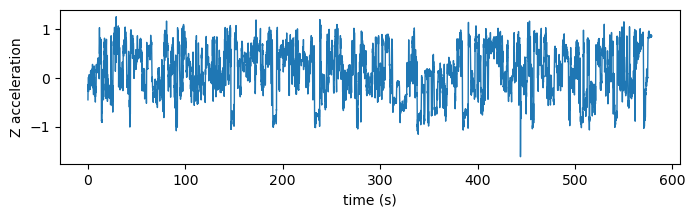

In [5]:
# accX = df['accX']
# accY = df['accY']
# accZ = df['accZ']
# x = pd.to_datetime(df['time'], unit='ms')
# print(x[0])
# print(x[1])
# print(x[2])
accX = df['wristX']
accY = df['wristY']
accZ = df['wristZ']

fs = 15
period = 1/fs
x = np.linspace(0, len(accX)*period, len(accX), endpoint=True)

print(x[0])
print(x[1])
print(x[2])
      
plt.subplots(1,1, figsize=(8, 2))

plt.plot(x, accX, linewidth=1)
plt.title('3 subplots',)
plt.ylabel('X acceleration')

plt.subplots(1, 1, figsize=(8, 2))
plt.plot(x, accY, linewidth=1)
plt.xlabel('time (s)')
plt.ylabel('Y acceleration',)

plt.subplots(1, 1, figsize=(8, 2))
plt.plot(x, accZ, linewidth=1)
plt.xlabel('time (s)')
plt.ylabel('Z acceleration')

plt.show()

In [8]:
class Windowed_peak():
    
    def __init__(self, accX, accY, accZ, time, cont_window_size=0.33, step_length=0.067, var_threshold=0.01, continuity_threshold=0.4, k=6):
        self.accX = accX
        self.accY = accY
        self.accZ = accZ
        self.time = time
        self.step_length = step_length
        self.timestep = 0
        self.max_T = accX.shape[0]
        self.magnitudes = []
        self.bins = []
        self.peak_of_bins = []
        self.peak_diffs = []
        self.peak_similarities = []
        self.cont_window_size = cont_window_size
        self.var_threshold = var_threshold
        self.continuity_threshold = continuity_threshold
        self.peak_continuities = []
        self.k = k
        
    def set_time(self, time):
        self.time = time
        
    def get_time(self):
        return self.time
    
    def calculate_t_magnitude(self, timestep):
        """
        Calculate the Magnitude of acceleration by rooting the sum of squares of accX, accY and accZ 
        """
        return math.sqrt(accX[timestep]**2 + accY[timestep]**2 + accZ[timestep]**2)
    
    def calculate_magnitudes(self):
        """
        Calculate the the magnitude of acceleration for instance in the dataset
        """
        magnitudes = [self.calculate_t_magnitude(t) for t in range(0, self.max_T)]
        self.magnitudes = magnitudes
    
    def create_bins(self, k = None):
        """
        Split the dataset in bins of len=k
        Afterwards add these to the self.bins field of the class
        """
        if k is None:
            k = self.k

        bins = []
        n_bins = int(self.max_T/k)
        remainder = self.max_T%k
        
        for b in range(0, n_bins):
            bin = []
            for i in range(0, k):
                bin.append(self.magnitudes[b+i])
            bins.append(bin)
            
            
        if remainder > 0: 
            bins.append(self.magnitudes[self.max_T-remainder-1: self.max_T-1]) # If the the final bin has a length < k
        self.bins = bins
        
    def find_peak(self, bin, n):
        """
        Find the maximum magnitude value of the n'th bin and return it's index and value
        """
        return max(bin), np.argmax(bin), self.time[n*6+np.argmax(bin)]
    
    def find_peaks(self):
        """
        Find the maximum magnitude values for all bins and append these to the field self.peak_of_bins of the class
        """
        self.peak_of_bins = [self.find_peak(bin, n) for n, bin in enumerate(self.bins)]
    
    def similarity(self, n):
        """
        Calculate the similarity of the peak from the n'th bin.
        The peak of the last and second last bin can't be compared to the n+2'th one, therefore we return a similarity score of -99, such that it cannot hit the threshold
        For all the other cases we just take the absolute value of the difference between the n'th peak and the n+2'th peak
        Finally, return the similarity score
        """
        if n == len(self.time)-2:
            return -99
        return -abs(self.peak_of_bins[n][0] - self.peak_of_bins[n+2][0])
    
    def continuity(self, n):
        """
        Calculate the continuity for the peak of the n'th bin
        Start by checking if there is space to create a continuity window
        If there is no space:
            -> Return 0
        Else:
            -> Create windows for every timeframe in a bin
            -> For every window calculate the variance
            -> If the variance is higher than the variance threshold said window is continuous
            -> If |Continuous windows| * step_length (in seconds) > continuity threshold
                return true
            -> Else return False
        """
        if n < self.cont_window_size or n > len(self.peak_of_bins)-5:
            return 0
        
        continuity_len = 0
        idx_in_bin = n*self.k
        for idx in range(idx_in_bin, idx_in_bin+self.k): # Iterate through all timesteps in a bin and retrieve windows for every timestep
            
            window_start, window_end = self.create_window(idx)
            window = self.magnitudes[window_start:window_end]
            var = np.array(window).var()
            if var > self.var_threshold:
                continuity_len += 1
                
        if continuity_len*self.step_length > self.continuity_threshold:
            return True
        return False
        
        
        
    def create_window(self, n):
        """
        Create a bin of length=cont_window_size for timestep n in the datapoint
        Return the start and end of the window
        """
        window_end = n+1
        window_end_t = self.time[n+1]
        
        window_start = 0
        
        for i, frame in reversed(list(enumerate(self.magnitudes))):
            if window_end_t - self.time[i] >= self.cont_window_size:
                window_start = i
                break
                
        return window_start, window_end
            
            
              
    def peak_diff(self, n):
        """
        Calculate the periodicity of a peak of the n'th bin
        The periodicity is calculated by calculating the time interval of two peaks
        Return the periodicity
        """
        if n == len(self.time)-1:
            return 0
        
        t_next_peak = self.peak_of_bins[n+1][2]
        t_curr_peak = self.peak_of_bins[n][2]
        
        return t_next_peak-t_curr_peak
            
    def __call__(self):
        step_list = []
        self.calculate_magnitudes()
        self.create_bins()
        self.find_peaks()
        peak_distance = 0
        n_peaks = len(self.peak_of_bins)
        
        for n in range(n_peaks-2):
            if self.peak_of_bins[n][0] < 0.8:
                step_list.append(0)
            else:
                step_bool = False
                self.peak_diffs.append(self.peak_diff(n))
                self.peak_similarities.append(self.similarity(n))
                self.peak_continuities.append(self.continuity(n))

                if self.peak_diffs[n] < 1 and self.peak_diffs[n] > 0.2 and self.peak_similarities[n] > -1 and self.peak_continuities[n]:
                    step_bool = True
                step_list.append((step_bool, n*6+self.peak_of_bins[n][1]))
        
        return step_list

In [9]:
WP = Windowed_peak(accX,accY,accZ, x)
steps = WP()
all_steps = [x for i, x in enumerate(steps) if x[0]]
print('steps found in dataset using windowed peak', len(all_steps))
print('steps found in dataset with ground truth ', len(df_ground_truth))

steps found in dataset using windowed peak 212
steps found in dataset with ground truth  199


In [ ]:
library(GGIR)
GGIR(datadir="~/Verisense-Toolbox/Data/P001/Irregular/",
outputdir="~/",
mode=1:2,
epochvalues2csv = TRUE,
do.report=2,
myfun=myfun) #<= this is where object myfun is provided to GGIR